In [1]:
# run on pth-gpu on HP Omen
# pth in FUM
# -*- coding: utf-8 -*-
import pickle as pkl
import pandas as pd
import numpy as np
import math
import os
import numpy.linalg as la
from input_data import preprocess_data,load_sz_data,load_los_data

from visualization import plot_result,plot_error
from sklearn.metrics import mean_squared_error,mean_absolute_error
#import matplotlib.pyplot as plt
import time

time_start = time.time()
###### Settings ######
data_name = 'los'#'sz' #'los'

###### load data ######
if data_name == 'sz':
    data, adj = load_sz_data('sz')
    # Drop the first 11 days
    # data = data.drop(data.index[:1056])
if data_name == 'los':
    data, adj = load_los_data('los')


time_len = data.shape[0]
num_nodes = data.shape[1]
data1 =np.mat(data,dtype=np.float32)

#### normalization
max_value = np.max(data1)
data1 = data1/max_value

ModuleNotFoundError: No module named 'input_data'

In [16]:
type(adj[0,0])

numpy.float64

In [17]:
print(time_len, num_nodes)
print(data.shape, data1.shape)

2016 207
(2016, 207) (2016, 207)


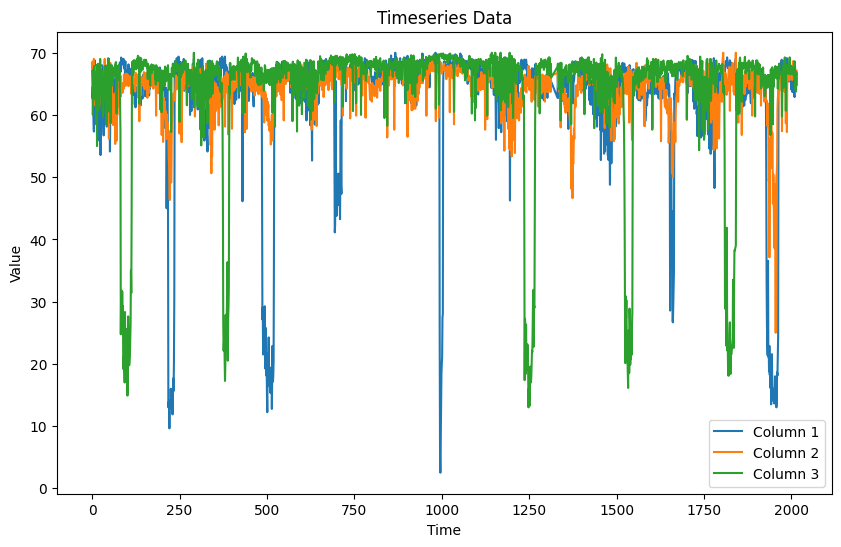

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some sample data
# X = data[:,0]

# Plot all the columns of X in a single plot
plt.figure(figsize=(10, 6))  # Set the figure size

for i in range(3):  # Loop through each column of X
    plt.plot(data.iloc[:, i], label=f'Column {i+1}')  # Plot the column data with a label

plt.xlabel('Time')  # Set the x-axis label
plt.ylabel('Value')  # Set the y-axis label
plt.title('Timeseries Data')  # Set the title of the plot
plt.legend()  # Show the legend

plt.show()  # Show the plot


In [19]:
X = data.values
X.shape

(2016, 207)

In [20]:
from dagma import utils
from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear

In [21]:
# !pip install dagma

In [22]:
%%time
model = DagmaLinear(loss_type='l2') # create a linear model with least squares loss
W_est = model.fit(X, lambda1=0.02) # fit the model with L1 reg. (coeff. 0.02)
print(W_est.shape)


  0%|          | 0/180000.0 [00:00<?, ?it/s]

(207, 207)
CPU times: total: 4min 19s
Wall time: 2min 36s


In [23]:
W_true = adj
acc = utils.count_accuracy(W_true, W_est != 0) # compute metrics of estimated adjacency matrix W_est with ground-truth
print(acc)

{'fdr': 0.2048780487804878, 'tpr': 1.0575361807271444, 'fpr': 0.0022717438338381653, 'shd': 1399, 'nnz': 205}


In [24]:
W_true_normalized = (W_true - np.min(W_true)) / (np.max(W_true) - np.min(W_true)) * 255
W_est_normalized = (W_est - np.min(W_est)) / (np.max(W_est) - np.min(W_est)) * 255

# Convert to uint8
W_true_img = W_true_normalized.astype(np.uint8)
W_est_img = W_est_normalized.astype(np.uint8)

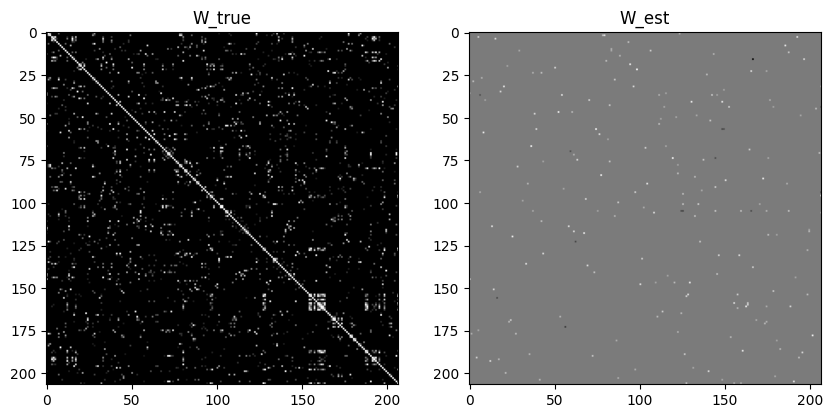

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(adj, cmap='gray')
axs[0].set_title('W_true')

axs[1].imshow(W_est_img, cmap='gray')
axs[1].set_title('W_est')

plt.show()


In [26]:
W_est_file_name = f"est_adj/W_est_{data_name}.npy"
np.save(W_est_file_name, W_est)

In [29]:
import numpy as np
W_est = np.load(W_est_file_name)
type(W_est[0,0])

numpy.float64

In [28]:
adj = np.zeros(W_est.shape, dtype=int)

# Update values in adj based on the condition
adj[W_est > 0] = 1
# Initialize a counter
count = 0

# Iterate through each element in the matrix
for row in adj:
    for value in row:
        if value > 0:
            count += 1

# Print the count
print("Number of values greater than 0 in the matrix: ", count)


Number of values greater than 0 in the matrix:  191


In [30]:
adj = np.zeros(W_est.shape, dtype=int)

# Update values in adj based on the condition
adj[W_true > 0] = 1
# Initialize a counter
count = 0

# Iterate through each element in the matrix
for row in adj:
    for value in row:
        if value > 0:
            count += 1

# Print the count
print("Number of values greater than 0 in the matrix: ", count)

Number of values greater than 0 in the matrix:  2833


In [31]:
count = 0
for i in range(W_true.shape[0]):
    for j in range(W_true.shape[1]):
        if W_est[i, j] > 0 and W_true[i, j] == 0:
            count += 1

print("Number of elements > 0 in W_est and equal to 0 in W_true:", count)

Number of elements > 0 in W_est and equal to 0 in W_true: 30
